In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import yfinance as yf

# --- InfluxDB config ---
INFLUXDB_URL = "http://localhost:10896"
INFLUXDB_TOKEN = "14iJvsBJKp37nLXjIZvE4RbAoEO2dNs1k0GvCbKuJUnF_ub4pSWWw80O739jabLPMD-XBzA72WSX9f-4FuDBQ=="
INFLUXDB_ORG = "bdinf-org"
INFLUXDB_BUCKET = "bdinf-bucket"


TICKER = "GOOG"  # Change to the ticker you want to analyze
START_DATE = "2024-01-01"
END_DATE = "2024-12-31"

In [20]:

#--- Connect to InfluxDB and query data ---
client = InfluxDBClient(url=INFLUXDB_URL, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)
query_api = client.query_api()

query = f'''
from(bucket: "{INFLUXDB_BUCKET}")
  |> range(start: {START_DATE}T00:00:00Z, stop: {END_DATE}T23:59:59Z)
  |> filter(fn: (r) => r["_measurement"] == "sentiment_data")
  |> filter(fn: (r) => r["ticker"] == "{TICKER}")
  |> filter(fn: (r) => r["_field"] == "avg_sentiment_score")
  |> aggregateWindow(every: 1d, fn: mean)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> yield(name: "pivoted")
'''

# Run the query
df = query_api.query_data_frame(org=INFLUXDB_ORG, query=query)

# Clean up the sentiment DataFrame
sentiment_df = df[['_time', 'avg_sentiment_score']].rename(columns={'_time': 'Date', 'avg_sentiment_score': 'Sentiment'})
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df.set_index('Date', inplace=True)

In [21]:
# --- Fetch Yahoo Finance data (NOTE: auto_adjust=True is now default) ---
yf_df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)

# Flatten MultiIndex columns if needed
if isinstance(yf_df.columns, pd.MultiIndex):
    yf_df.columns = yf_df.columns.get_level_values(0)

yf_df = yf_df[['Adj Close']].rename(columns={'Adj Close': 'Price'})

[*********************100%***********************]  1 of 1 completed


In [22]:
sentiment_df.index = sentiment_df.index.tz_localize(None)  # remove timezone
yf_df.index = yf_df.index.tz_localize(None)

# --- Merge and normalize ---
merged = sentiment_df.join(yf_df, how='inner')
merged.dropna(inplace=True)

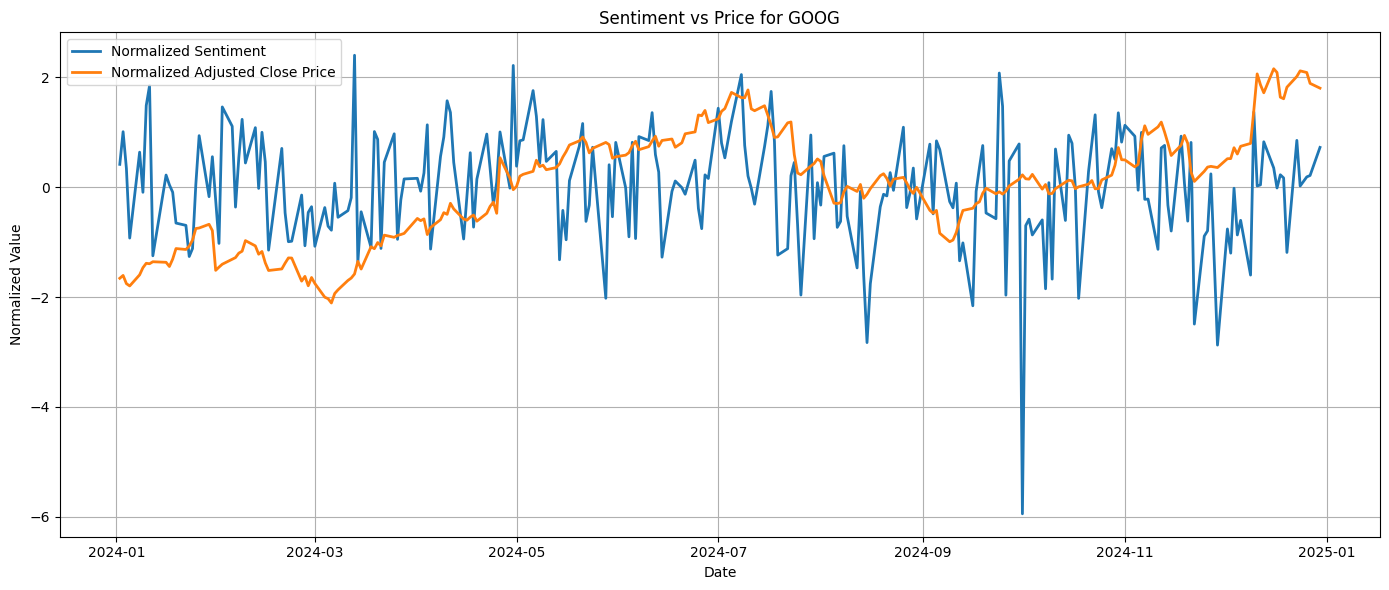

In [23]:

merged['Sentiment_norm'] = (merged['Sentiment'] - merged['Sentiment'].mean()) / merged['Sentiment'].std()
merged['Price_norm'] = (merged['Price'] - merged['Price'].mean()) / merged['Price'].std()

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(merged.index, merged['Sentiment_norm'], label='Normalized Sentiment', linewidth=2)
plt.plot(merged.index, merged['Price_norm'], label='Normalized Adjusted Close Price', linewidth=2)
plt.title(f"Sentiment vs Price for {TICKER}")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()